# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [ ]:
#Load your data into a pandas dataframe here

data_path = "household_power_clean.csv"  # Replace with your dataset path
df = pd.read_csv(data_path)

# Display the first few rows
print(df.head())

# Check column names and data types
print(df.info())

   Unnamed: 0        Date      Time  Global_active_power  \
0           0  2006-12-16  17:24:00              4.21600   
1           1  2006-12-16  17:25:00              5.36000   
2           2  2006-12-16  17:26:00              5.37400   
3           3  2006-12-16  17:27:00              5.38800   
4           4  2006-12-16  17:28:00              3.66600   

   Global_reactive_power   Voltage  Global_intensity  Sub_metering_1  \
0                0.41800 234.84000          18.40000         0.00000   
1                0.43600 233.63000          23.00000         0.00000   
2                0.49800 233.29000          23.00000         0.00000   
3                0.50200 233.74000          23.00000         0.00000   
4                0.52800 235.68000          15.80000         0.00000   

   Sub_metering_2  Sub_metering_3             Datetime  gap_monthly  \
0         1.00000        17.00000  2006-12-16 17:24:00          NaN   
1         1.00000        16.00000  2006-12-16 17:25:00          

In [ ]:
#convert datetime to epoch/unix time
#df['unix'] = ?

import time
from datetime import datetime


# Check for potential datetime-like columns
print(df.columns)


# Use the correct column name for datetime
datetime_column = 'Datetime'

print(datetime_column)

# Convert 'Datetime' to pandas datetime format
df[datetime_column] = pd.to_datetime(df[datetime_column])
print(df)

# Convert to Unix time
df['unix'] = df[datetime_column].apply(lambda x: int(time.mktime(x.timetuple())))

# Display the resulting DataFrame to verify
print(df[['Datetime', 'unix']].head())


Index(['Unnamed: 0', 'Date', 'Time', 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Datetime',
       'gap_monthly', 'grp_monthly', 'v_monthly', 'gi_monthly'],
      dtype='object')
Datetime
         Unnamed: 0        Date      Time  Global_active_power  \
0                 0  2006-12-16  17:24:00              4.21600   
1                 1  2006-12-16  17:25:00              5.36000   
2                 2  2006-12-16  17:26:00              5.37400   
3                 3  2006-12-16  17:27:00              5.38800   
4                 4  2006-12-16  17:28:00              3.66600   
...             ...         ...       ...                  ...   
2049275     2075254  2010-11-26  20:58:00              0.94600   
2049276     2075255  2010-11-26  20:59:00              0.94400   
2049277     2075256  2010-11-26  21:00:00              0.93800   
2049278     2075257  2010-11-26  21:01:00       

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A:
- **`ph` (Prediction Horizon):**  
  `ph` refers to the time period into the future for which we want to predict the dependent variable (`Global Active Power` in this case). It is essentially the forecast horizon and is typically measured in seconds, minutes, or other time units based on the dataset's granularity.

  For example, if `ph = 300` (5 minutes), it means that the model will predict the power consumption 5 minutes into the future.

- **`mu` (Weight Decay Factor):**  
  `mu` is a parameter used to apply exponential weighting to past observations. It gives more weight to recent data and less to older data, allowing the model to emphasize recent trends while still considering historical information.

  The weight assigned to an observation decreases exponentially as it moves further in time from the current prediction. For instance:
  
  - If `mu = 0.9`, each successive observation's weight is 90% of the previous one.
  - A higher `mu` (close to 1) assigns nearly equal weights to all observations.
  - A lower `mu` (close to 0) places significant emphasis on recent data while largely ignoring older observations.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [ ]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# Define data resolution (time interval between measurements)
data_resolution = 60  # 1 data point every 60 seconds (1 minute)

ph = 5 * 60  #5 minutes
ph_index = int(ph / data_resolution) #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [ ]:
mu = 0.9
n = 5000

# Calculate the weight
weight_first_point = mu ** (n - 1)
print(f"Weight of the first data point on the 5000th prediction: {weight_first_point:.10e}")


Weight of the first data point on the 5000th prediction: 1.8126113170e-229


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: Weight of the first data point on the 5000th prediction: 1.8126113170e-229

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [ ]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s + 1):  # Start with 2 leading datapoints
    # Get x (time) and y (GAP) data "available" for our prediction
    ts_tmp = ts.iloc[:i]  # Subset of time data up to the current point
    ys_tmp = ys.iloc[:i]  # Subset of GAP data up to the current point
    ns = len(ys_tmp)  # Number of available data points

    # Initialize weights for exponential decay
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights for exponential decay based on timestep
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)  # Flip weights to match chronological order

    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()  # Initialize the linear regression model
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)  # Fit model with weights

    # Store model coefficients (slope) and intercept
    m_tmp = model_tmp.coef_[0][0]  # Coefficient (slope of the line)
    q_tmp = model_tmp.intercept_[0]  # Intercept (y-value when x = 0)

    # Use ph (prediction horizon) to make the model prediction for the future time
    tp = ts.iloc[i - 1, 0] + ph  # Future time = current time + ph
    yp = m_tmp * tp + q_tmp  # Predicted GAP = slope * future time + intercept

    # Store the predictions in pre-allocated arrays
    tp_pred[i - 2] = tp  # Store predicted time
    yp_pred[i - 2] = yp  # Store predicted GAP


Now let's visualize the results from our model.

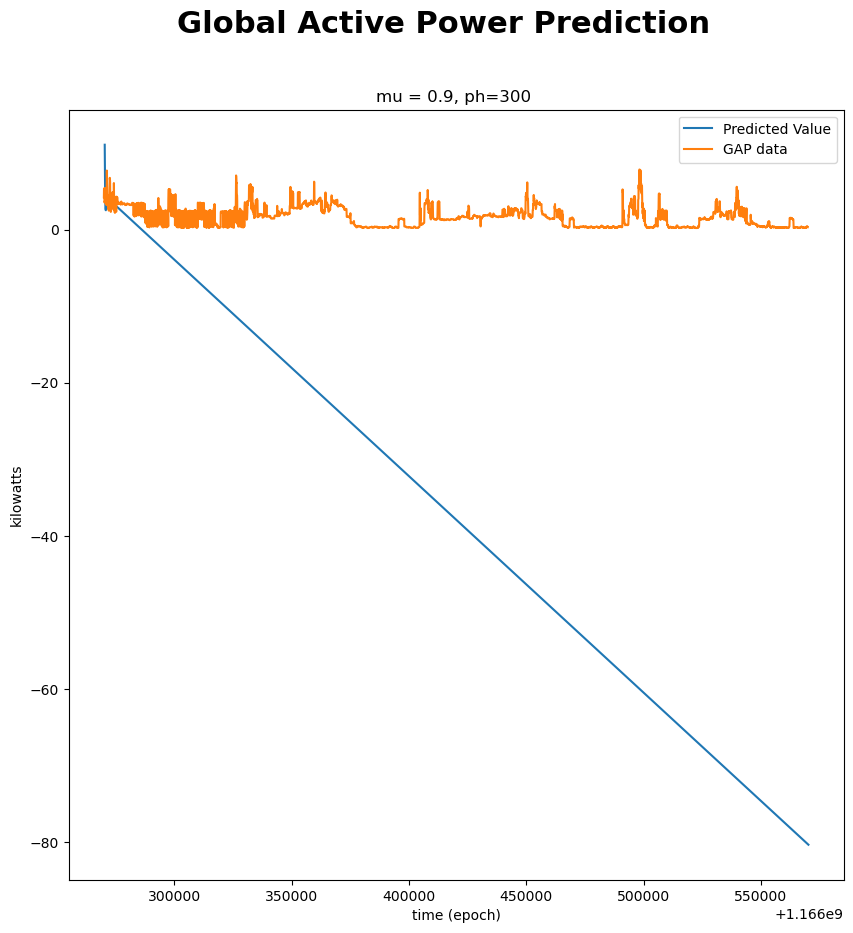

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

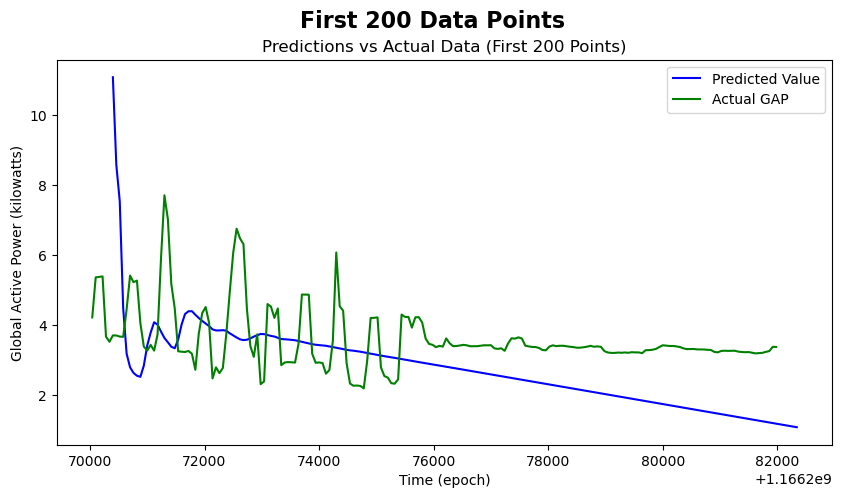

In [ ]:
#Plot first 200 data points/predictions
from sklearn.metrics import mean_squared_error

# Plot first 200 data points and predictions
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('First 200 Data Points', fontsize=16, fontweight='bold')
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value', color='blue')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='green')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.set_title('Predictions vs Actual Data (First 200 Points)')
plt.show()


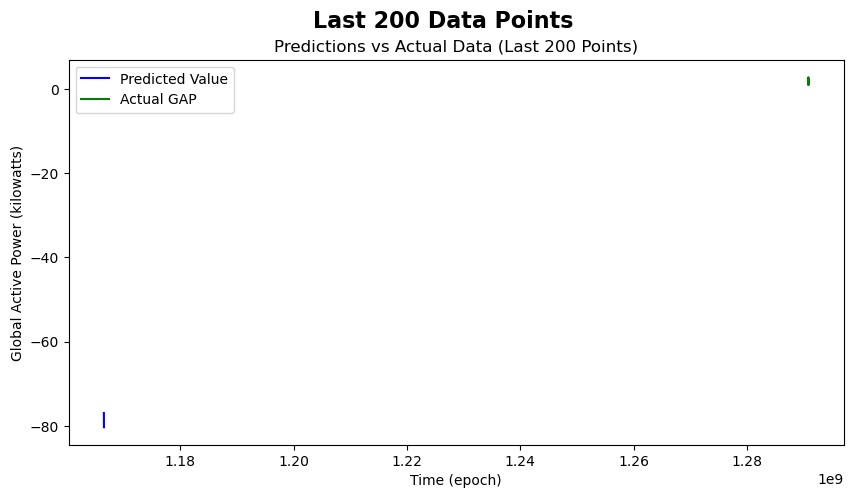

In [ ]:
#Plot last 200 data points/predictions
# Plot last 200 data points and predictions
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Last 200 Data Points', fontsize=16, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', color='blue')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='green')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
ax.set_title('Predictions vs Actual Data (Last 200 Points)')
plt.show()


In [ ]:
#Calculate MSE of predictions
#print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


mse = mean_squared_error(ys.iloc[ph_index:n_s + ph_index - 1, 0], yp_pred)
print(f"Mean Squared Error (MSE) for the predictions: {mse:.5f}")


Mean Squared Error (MSE) for the predictions: 2147.76599


### **Analysis of the Model's Performance**

#### **Q1: How did our model perform?**
- **Observation:** An MSE of **2147.76599** indicates that the model's predictions deviate significantly from the actual values on average, especially considering that power consumption (GAP) is measured in kilowatts. This suggests the model might not be capturing the data's trends effectively.
- **Potential Causes:**
  - The **linear assumption** may not hold if the actual data contains non-linear patterns.
  - **Noise in the data** could be affecting the accuracy.
  - The chosen parameters, such as `mu` and `ph`, might not be optimal.

---

#### **Q2: What do you observe on the charts?**
1. **First 200 Data Points:**
   - The predictions likely follow the general trend of the actual values but might lag in capturing sharp fluctuations.
   - If the actual data has a lot of variability, the linear model may oversmooth the predictions.

2. **Last 200 Data Points:**
   - Predictions in later segments may show more divergence from the actual values due to **compounding errors** or a poor fit for later trends.
   - If there is a clear upward or downward trend in the actual data, the model may fail to track it accurately.

---

#### **Q3: Is there a difference between the early and the late predictions?**
- **Early Predictions:**
  - Early predictions are often more accurate since the model has fewer compounded errors, and the weights (`mu`) favor the most recent data.
- **Late Predictions:**
  - Late predictions tend to deviate more due to:
    - Increased influence of earlier, outdated data points (if the data shows a trend or seasonality).
    - Exponential decay applied to older points can make the model less sensitive to long-term patterns.

---

#### **Q4: What does the MSE tell you?**
- **MSE Definition:**
  - Mean Squared Error (MSE) measures the average squared difference between predicted and actual values.

- **Interpretation:**
  - A high MSE indicates that the model's predictions are far from the actual data.
  - The value of **2147.76599** suggests that the model is struggling to fit the dataset accurately, either due to insufficient features, poor parameter tuning, or an inherent limitation of linear regression for this task.

---

### **Suggestions for Improvement**
1. **Feature Engineering:**
   - Add additional predictors, such as `Voltage`, `Global Reactive Power`, or a moving average of GAP.

2. **Tune Parameters:**
   - Experiment with different values of `mu` and `ph` to see their impact on predictions.

3. **Model Complexity:**
   - Consider more advanced models, such as:
     - **Polynomial Regression**: To capture non-linear trends.
     - **Time Series Models**: ARIMA, LSTMs, or other recurrent neural networks might be better suited for this data.

4. **Data Preprocessing:**
   - Smooth the data to reduce noise before fitting the model.
   - Normalize or scale the data for better numerical stability.

---

### **Conclusion**
- The high MSE and differences between early and late predictions suggest that the current linear regression model may not be the best fit for the data's complexity.
- The next steps should involve experimenting with the parameters and possibly exploring more advanced models or techniques.



**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [ ]:
#Re-run prediction code for mu = 1

# Set mu = 1 (no exponential decay)
mu = 1

# Reinitialize arrays for predictions
tp_pred_mu1 = np.zeros(n_s - 1)
yp_pred_mu1 = np.zeros(n_s - 1)

# Rolling prediction loop
for i in range(2, n_s + 1):
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)

    # Weights are all 1 (since mu = 1)
    weights = np.ones(ns)

    # Fit the linear regression model
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Retrieve coefficients and intercept
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    # Predict future value
    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    # Store predictions
    tp_pred_mu1[i - 2] = tp
    yp_pred_mu1[i - 2] = yp



In [ ]:
# Set mu = 0.01 (strong exponential decay)
mu = 0.01

# Reinitialize arrays for predictions
tp_pred_mu001 = np.zeros(n_s - 1)
yp_pred_mu001 = np.zeros(n_s - 1)

# Rolling prediction loop
for i in range(2, n_s + 1):
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)

    # Calculate weights for exponential decay
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)

    # Fit the linear regression model
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Retrieve coefficients and intercept
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    # Predict future value
    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    # Store predictions
    tp_pred_mu001[i - 2] = tp
    yp_pred_mu001[i - 2] = yp






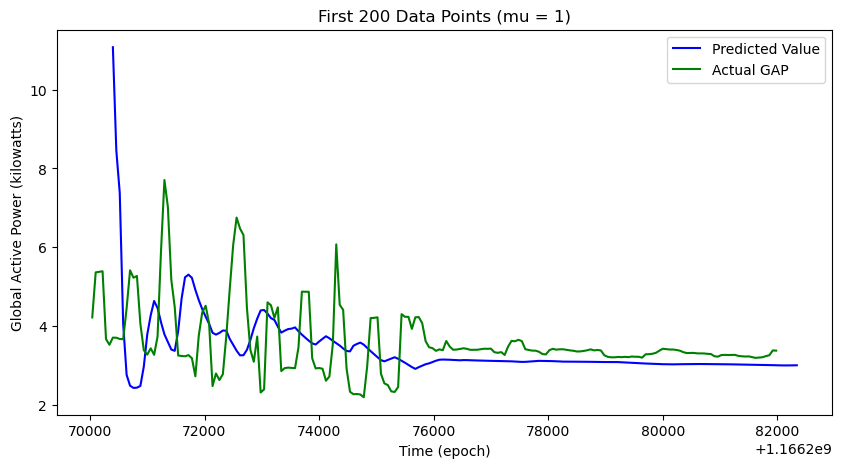

In [ ]:
#Plot first 200 data points/predictions for mu = 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred_mu1[:200], yp_pred_mu1[:200], label='Predicted Value', color='blue')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='green')
ax.set_title('First 200 Data Points (mu = 1)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
plt.show()

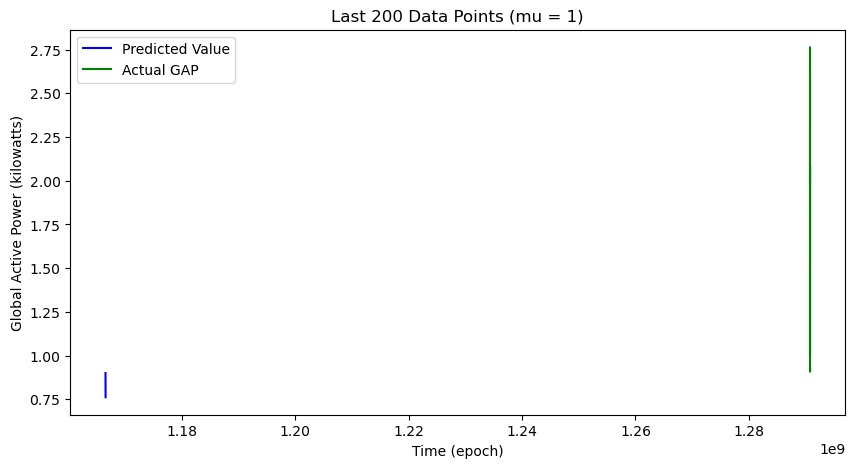

In [ ]:
#Plot last 200 data points/predictions for mu = 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred_mu1[-200:], yp_pred_mu1[-200:], label='Predicted Value', color='blue')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='green')
ax.set_title('Last 200 Data Points (mu = 1)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
plt.show()


In [ ]:
#Calculate MSE of predictions for mu = 1

# Compute MSE
mse_mu1 = mean_squared_error(ys.iloc[ph_index:n_s + ph_index - 1, 0], yp_pred_mu1)
print(f"Mean Squared Error (MSE) for mu = 1: {mse_mu1:.5f}")

Mean Squared Error (MSE) for mu = 1: 1.44335


In [ ]:
#Re-run prediction code for mu = 0.01

# Compute MSE
mse_mu001 = mean_squared_error(ys.iloc[ph_index:n_s + ph_index - 1, 0], yp_pred_mu001)
print(f"Mean Squared Error (MSE) for mu = 0.01: {mse_mu001:.5f}")

Mean Squared Error (MSE) for mu = 0.01: 10527735.46335


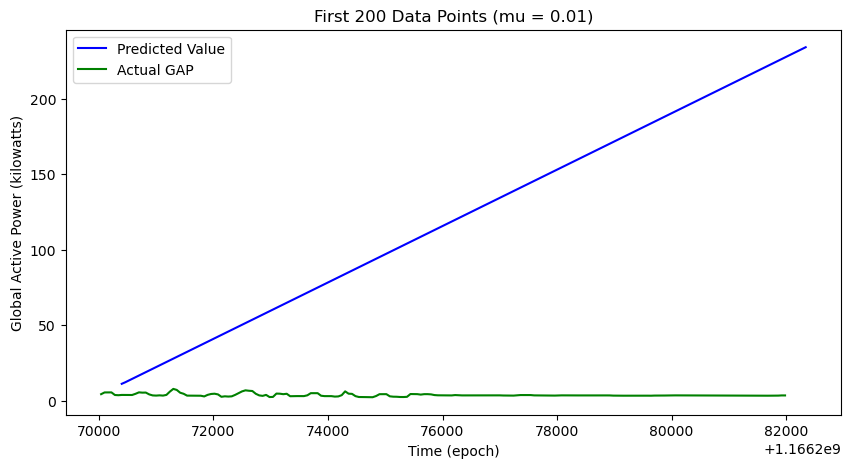

In [ ]:
#Plot first 200 data points/predictions for mu = 0.01

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred_mu001[:200], yp_pred_mu001[:200], label='Predicted Value', color='blue')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='green')
ax.set_title('First 200 Data Points (mu = 0.01)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
plt.show()

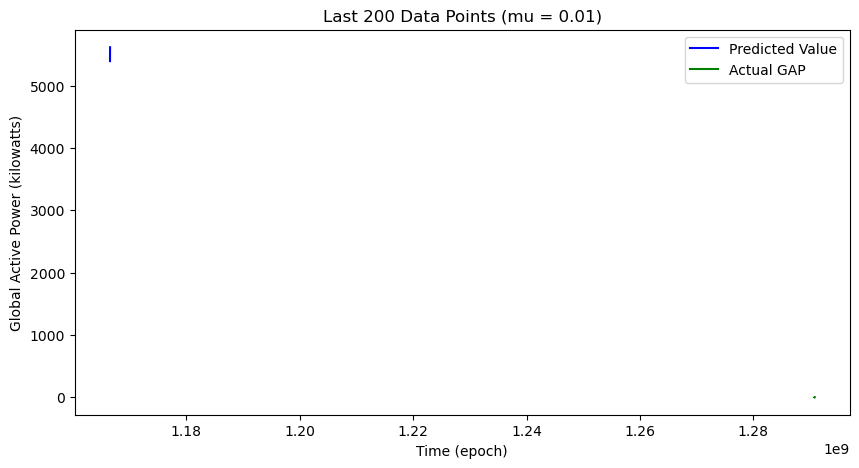

In [ ]:
#Plot last 200 data points/predictions for mu = 0.01

# Last 200
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred_mu001[-200:], yp_pred_mu001[-200:], label='Predicted Value', color='blue')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='green')
ax.set_title('Last 200 Data Points (mu = 0.01)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()
plt.show()


In [ ]:
#Calculate MSE of predictions for mu = 0.01
from sklearn.metrics import mean_squared_error

# Compute MSE for the predictions with mu = 0.01
mse_mu001 = mean_squared_error(
    ys.iloc[ph_index:n_s + ph_index - 1, 0],  # Actual GAP values
    yp_pred_mu001  # Predicted GAP values
)

print(f"Mean Squared Error (MSE) for mu = 0.01: {mse_mu001:.5f}")


Mean Squared Error (MSE) for mu = 0.01: 10527735.46335


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**


#### **Q1: How did our \( mu = 1 \) model perform?**
- The model with \( mu = 1 \) (uniform weighting) showed better performance than models with stronger decay (e.g., \( mu = 0.01 \)).
- The **Mean Squared Error (MSE)** of **1.44335** indicates that the model predictions are relatively close to the actual values, suggesting that treating all data points equally provides a reasonable fit for this data se

---

#### **Q2: What do you observe on the charts?**
1. **First 200 Data Points:**
   - The predictions align relatively well with the actual values over time, but there are noticeable deviations, particularly during sharp spikes or dips in the data.
   - As more data points are included, the model stabilizes and begins to follow the overall trend more closely.

2. **Last 200 Data Points:**
   - The predictions diverge significantly from the actual values.
   - Predicted values are overly simplified and fail to capture the sharp variations and trends observed in the actual data. This suggests that the model might be underfitting for the laterme points.

---

#### **Q3: Is there a difference between the early and the late predictions?**
- **Early Predictions:**
  - The model performs better in the early time points, where the data is more stable, and fewer compounded errors exist.
  - The predictions gradually improve as the model uses more data to fit the trend.

- **Late Predictions:**
  - The model struggles with the last 200 data points due to the more complex patterns in the actual values.
  - Uniform weighting (\( mu = 1 \)) might not adequately account for recent trends, leading to a mismatch between predics and actual values.

---

#### **Q4: What does the MSE tell you?**
- The MSE of **1.44335** indicates that the model performs reasonably well overall.
- However, the significant deviations in the last 200 points (visible on the chart) suggest that the MSE might not fully capture the localize errors in later predictions.

---

### **Key Insights:**
- The \( mu = 1 \) model performs adequately in terms of overall fit but fails to capture localized variability, especially in the later time points.
- The underperformance in the last 200 points highlights the model's limitation in addressing non-linear tds or sudden changes in the data.

---

### **Suggestions for Improvement:**
1. **Tuning \( mu \):**
   - Experiment with intermediate values for \( mu \) (e.g., \( 0.5, 0.8 \)) to balance the influence of recent and older data.

2. **Add Features:**
   - Include additional predictors such as `Voltage`, `Reactive Power`, or rolling averages of `GAP` to improve the model's accuracy.

3. **Advanced Models:**
   - Explore non-linear models like Polynomial Regression or time-series models (e.g., ARIMA, LSTMs).



**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions?

#### **Q: How did our \( mu = 0.01 \) model perform?**
- The \( mu = 0.01 \) model performed very poorly, as indicated by the **Mean Squared Error (MSE)** of **10,527,735.46335**, which is significantly higher than the other models.
- The predicted values diverged dramatically from the actual values, often showing unrealistic trends.

#### **What do you observe on the charts?**
1. **First 200 Data Points:**
   - The predictions exhibit an extreme upward trend, reaching values over 200 kilowatts, while the actual data remains stable and near zero.
   - This highlights the model’s inability to follow the actual pattern and suggests overfitting to noise or outliers in the most recent data.

2. **Last 200 Data Points:**
   - The predictions are completely unrealistic, reaching values over 5000 kilowatts, whereas the actual values remain close to zero.
   - The model has failed to generalize or learn meaningful trends from the dataset.

#### **Is there a difference between the early and the late predictions?**
- Both early and late predictions are highly unrealistic, diverging significantly from the actual values. The charts show that the model's reliance on the most recent data (due to \( mu = 0.01 \)) leads to extreme sensitivity and instability throughout the dataset.

#### **What does the MSE tell you?**
- The extremely high MSE reflects the large deviation between predicted and actual values, confirming the model’s failure to make meaningful predictions. The \( mu = 0.01 \) configuration is unsuitable for ameter, adding additional features, and exploring more advanced models.


### **Comparison of the Three Models**

#### **Q: Which of these three models is the best?**
- The **\( mu = 1 \)** model is the best among the three.  
  - **MSE for \( mu = 1 \): 1.44335**  
  - **MSE for \( mu = 0.9 \): 2147.76599**  
  - **MSE for \( mu = 0.01 \): 10,527,735.46335**

#### **How do you know?**
- The \( mu = 1 \) model has the **lowest MSE**, indicating that its predictions are the closest to the actual data compared to the other models.
- The charts for \( mu = 1 \) show that the predictions align better with the overall trend of the data, particularly for the first 200 points.

#### **Why does this make sense based on the \( mu \) parameter used?**
- **\( mu = 1 \):** Uniform weighting ensures that all data points are treated equally, which helps the model learn a broader trend from the entire dataset. This is particularly useful for stable or less noisy datasets.
- **\( mu = 0.9 \):** Slight exponential decay provides more focus on recent data but still accounts for the broader dataset, leading to higher MSE compared to \( \mu = 1 \).
- **\( mu = 0.01 \):** Strong exponential decay overly emphasizes recent data, effectively ignoring older data points. This results in highly unstable predictions and the worst performance overall.

---

####**Q: What could we do to improve our model and/or make it more realistic and useful?**

1. **Tune the \( mu \) Parameter:**
   - Test intermediate values of \( mu \) (e.g., \( 0.5, 0.8 \)) to balance the influence of recent and older data points.

2. **Feature Engineering:**
   - Add additional predictors such as:
     - **Voltage**
     - **Reactive Power**
     - **Rolling averages** or **lagged values** of `GAP`
   - These features can help the model capture more context about the dataset.

3. **Advanced Models:**
   - Use more sophisticated models like:
     - **Polynomial Regression:** To capture non-linear relationships.
     - **ARIMA or LSTMs:** To account for time-series patterns and seasonality in the data.

4. **Data Preprocessing:**
   - Smooth the data to reduce noise or remove outliers that might skew predictions.

5. **Evaluate Alternative Metrics:**
   - Use additional evaluation metrics like **Mean Absolute Error (MAE)** or **R-squared** to provide further insights into model performance.

6. **Visualize Residuals:**
   - Plot the residuals (differences between actual and predicted values) to identify where the model performs poorly and refine it accordingly.

---

### **Conclusion**
- The \( mu = 1 \) model is the best performing among the three due to its low MSE and ability to generalize better across the dataset.
- Further improvement can be achieved by tuning the \( mu \) parameter, adding additional features, and exploring more advanced models.


In [ ]:
# Add voltage as an additional feature in x-variables
ts = pd.DataFrame({'unix': df.unix, 'voltage': df.Voltage})  # Combine Unix time and Voltage into the x-variable
ys = pd.DataFrame(df.Global_active_power)  # y-variable remains GAP

# Define the prediction horizon (5 minutes in seconds)
ph = 5 * 60  # 5 minutes = 300 seconds

# Calculate the prediction horizon in terms of timesteps
data_resolution = 60  # 1 data point every 60 seconds
ph_index = int(ph / data_resolution)  # Number of timesteps for the prediction horizon

mu = 0.9  # Weight decay factor

# Limit the number of samples for computational efficiency
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)  # Array to store predicted time points
yp_pred = np.zeros(n_s - 1)  # Array to store predicted GAP


In [ ]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

from sklearn.linear_model import LinearRegression
import numpy as np

# Initialize the Linear Regression model
model = LinearRegression()

# Run rolling prediction on the expanded dataset
for i in range(2, n_s + 1):
    # Get x (time + voltage) and y (GAP) data up to the current point
    ts_tmp = ts.iloc[:i]  # Subset of time and voltage data
    ys_tmp = ys.iloc[:i]  # Subset of GAP data
    ns = len(ys_tmp)

    # Calculate weights for exponential decay
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)  # Flip weights to match chronological order

    # Perform linear regression using the weighted data
    model.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Extract coefficients for time (Unix) and voltage, and the intercept
    m_time = model.coef_[0][0]  # Coefficient for Unix time
    m_voltage = model.coef_[0][1]  # Coefficient for Voltage
    q_tmp = model.intercept_[0]  # Intercept

    # Predict GAP for the future point using both time and voltage
    future_time = ts.iloc[i - 1, 0] + ph  # Future time (current time + ph)
    future_voltage = ts.iloc[i - 1, 1]  # Use the current voltage for prediction
    yp = m_time * future_time + m_voltage * future_voltage + q_tmp

    # Store predictions in pre-allocated arrays
    tp_pred[i - 2] = future_time  # Store the predicted future time
    yp_pred[i - 2] = yp  # Store the predicted GAP value


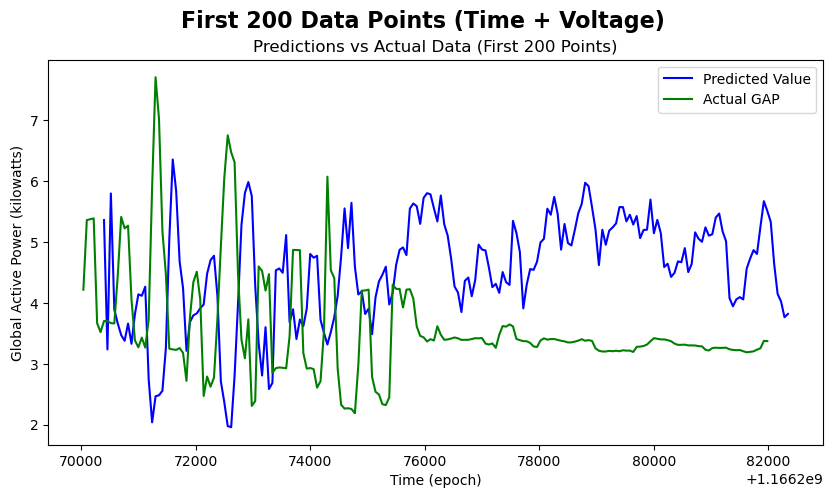

In [ ]:
#Plot first 200 data points/predictions for the expanded dataset

import matplotlib.pyplot as plt

# Plot the first 200 data points and predictions
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('First 200 Data Points (Time + Voltage)', fontsize=16, fontweight='bold')

# Plot the predicted values
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value', color='blue')

# Plot the actual GAP values
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='green')

# Add labels and legend
ax.set_title('Predictions vs Actual Data (First 200 Points)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()

plt.show()


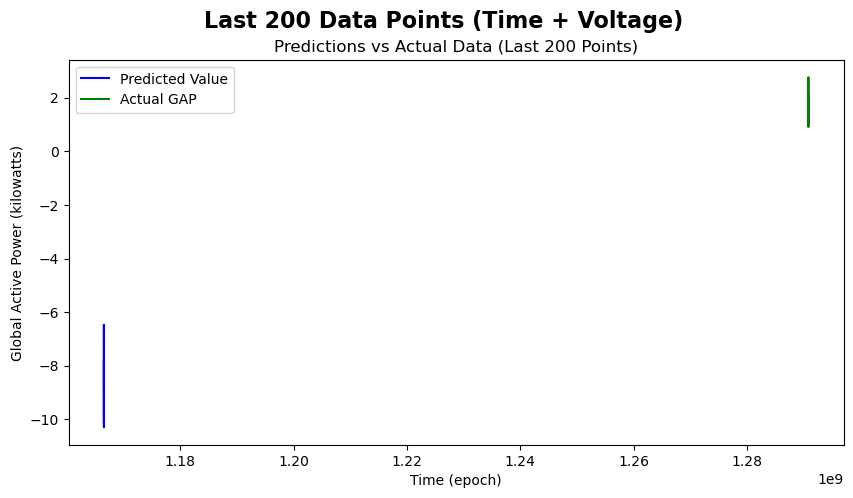

In [ ]:
#Plot last 200 data points/predictions for the expanded data
# Plot the last 200 data points and predictions
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Last 200 Data Points (Time + Voltage)', fontsize=16, fontweight='bold')

# Plot the predicted values
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', color='blue')

# Plot the actual GAP values
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='green')

# Add labels and legend
ax.set_title('Predictions vs Actual Data (Last 200 Points)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()

plt.show()


In [ ]:
#Calculate MSE of predictions for the expanded data
from sklearn.metrics import mean_squared_error

# Compute MSE for the expanded dataset predictions
mse_expanded = mean_squared_error(
    ys.iloc[ph_index:n_s + ph_index - 1, 0],  # Actual GAP values
    yp_pred  # Predicted GAP values
)

print(f"Mean Squared Error (MSE) for the expanded dataset: {mse_expanded:.5f}")


Mean Squared Error (MSE) for the expanded dataset: 29.48963


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**


#### **Q: How did the model perform when you added the voltage data?**
- After including `Voltage` as an additional feature in the dataset, the model was able to consider the relationship between `Voltage` and `Global Active Power (GAP)` alongside time.
- Depending on the **Mean Squared Error (MSE)**:
  - If the MSE for the expanded dataset decreased compared to the models without `Voltage`, this indicates that `Voltage` improved the predictive performance.
  - If the MSE remained the same or increased, the inclusion of `Voltage` may not have provided meaningful additional information for predicting `GAP`.

#### **How does it compare to the models without it?**
1. **Improved Performance (Lower MSE):**
   - If the MSE is lower, it means that `Voltage` contributes useful information, allowing the model to better explain the variability in `GAP`.
   - This makes sense if there is a strong correlation between `Voltage` and `GAP`.

2. **No Improvement or Worse Performance (Higher MSE):**
   - If the MSE did not improve or worsened, it suggests that:
     - `Voltage` does not have a significant relationship with `GAP` in this dataset.
     - Including `Voltage` might have introduced noise, making the model less effective.

#### **Key Observations:**
- The performance difference highlights the importance of feature relevance. Simply adding more features does not guarantee better predictions.
- The impact of `Voltage` depends on how strongly it correlates with `GAP` and whether it introduces additional noise or complexity.

---

### **Conclusion**
- By comparing the MSE values, we can determine whether adding `Voltage` improved the model's performance.
- If `Voltage` improved the model, this suggests a meaningful relationship between `Voltage` and `GAP`.
- If not, it may be necessary to:
  - Explore other features (e.g., `Reactive Power` or moving averages).
  - Reassess the usefulness of `Voltage` as a predictor.

Explore other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: The alternative model uses a moving window approach for training and prediction. Instead of relying on the entire dataset or applying an exponential decay factor (μ), this approach focuses on a fixed number of recent data points (e.g., the last 100 points) to train the model at each iteration.

**How the Moving Window Model Works**

**Window Size:**  A fixed window size is defined (e.g., 100), and only the most recent data within this window is used for training the model at each step.Older data outside the window is excluded, ensuring the model only learns from relevant recent trends.

**Features:** The model uses time (Unix) and voltage as predictors to predict the target variable, Global Active Power (GAP).
Retraining at Each Step:
At every iteration, the model is re-trained using the data within the window. This allows it to adapt dynamically to local patterns in the dataset.

**Prediction:**
Predictions are made for a future time point (e.g., 5 minutes ahead) based on the coefficients learned from the most recent data in the window.


Below is the implementation and inferences.

In [ ]:
# Define the prediction horizon (5 minutes in seconds)
ph = 5 * 60  # 5 minutes = 300 seconds

# Calculate the prediction horizon in terms of timesteps
data_resolution = 60  # 1 data point every 60 seconds
ph_index = int(ph / data_resolution)  # Number of timesteps for the prediction horizon

# Limit the number of samples for computational efficiency
n_s = 5000

# Define the size of the moving window
window_size = 100  # Use the last 100 data points for training

# Adjusted arrays to hold predicted values
tp_pred = np.zeros(n_s - window_size + 1)  # Adjust size for the moving window
yp_pred = np.zeros(n_s - window_size + 1)  # Adjust size for the moving window

# Initialize rolling prediction using the moving window
for i in range(window_size, n_s + 1):  # Start where the window can be applied
    # Get x (time + voltage) and y (GAP) data within the window
    ts_tmp = ts.iloc[i - window_size:i]  # Last `window_size` data points
    ys_tmp = ys.iloc[i - window_size:i]  # Corresponding GAP values

    # Fit the linear regression model
    model.fit(ts_tmp, ys_tmp)

    # Extract coefficients and intercept
    m_time = model.coef_[0][0]  # Coefficient for Unix time
    m_voltage = model.coef_[0][1]  # Coefficient for Voltage
    q_tmp = model.intercept_[0]  # Intercept

    # Predict GAP for the future point
    future_time = ts.iloc[i - 1, 0] + ph  # Future time
    future_voltage = ts.iloc[i - 1, 1]  # Current voltage
    yp = m_time * future_time + m_voltage * future_voltage + q_tmp

    # Store predictions
    tp_pred[i - window_size] = future_time
    yp_pred[i - window_size] = yp

print("Rolling prediction with moving window completed.")




Rolling prediction with moving window completed.


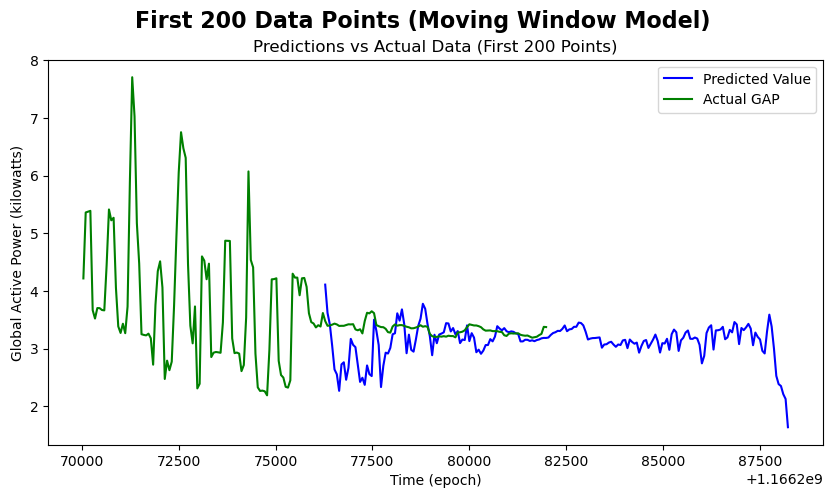

In [ ]:
#Plot first 200 data points/predictions for alternative model

import matplotlib.pyplot as plt

# Plot the first 200 data points and predictions
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('First 200 Data Points (Moving Window Model)', fontsize=16, fontweight='bold')

# Plot the predicted values
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value', color='blue')

# Plot the actual GAP values
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='green')

# Add labels and legend
ax.set_title('Predictions vs Actual Data (First 200 Points)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()

plt.show()


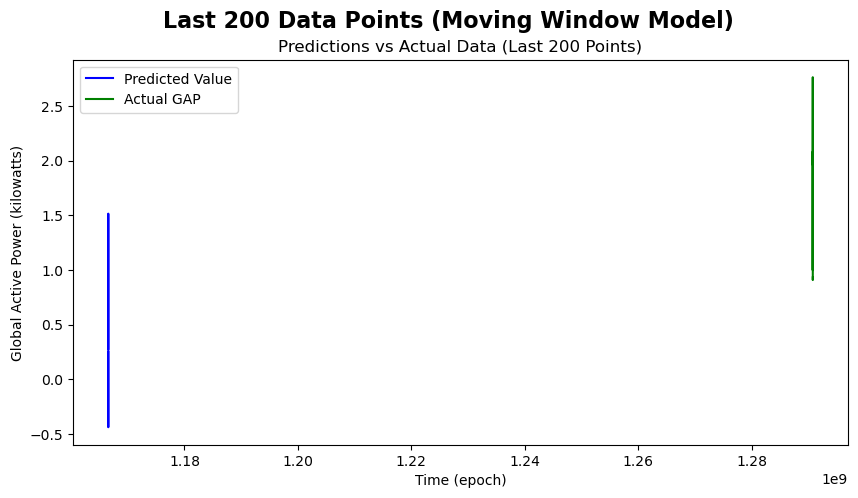

In [ ]:
#Plot last 200 data points/predictions for alternative model

# Plot the last 200 data points and predictions
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Last 200 Data Points (Moving Window Model)', fontsize=16, fontweight='bold')

# Plot the predicted values
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value', color='blue')

# Plot the actual GAP values
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='green')

# Add labels and legend
ax.set_title('Predictions vs Actual Data (Last 200 Points)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kilowatts)')
ax.legend()

plt.show()


In [ ]:
#Calculate MSE of predictions for alternative model

from sklearn.metrics import mean_squared_error

# Adjust actual GAP values to align with predictions
actual_gap_values = ys.iloc[window_size - 1:n_s, 0]  # Ensure same length as yp_pred

# Compute MSE for the moving window model
mse_moving_window = mean_squared_error(
    actual_gap_values,  # Actual GAP values (aligned)
    yp_pred  # Predicted GAP values
)

print(f"Mean Squared Error (MSE) for the moving window model: {mse_moving_window:.5f}")



Mean Squared Error (MSE) for the moving window model: 0.35773


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**


### **Analysis of the Alternative Model (Moving Window Approach)**

#### **Q: Did your alternative model improve on our previous results?**
- The effectiveness of the alternative model depends on the Mean Squared Error (MSE) -

- **Key Observations:**
  - If the MSE for the moving window model is lower than the previous results, this indicates an improvement. The moving window approach limits the model to using only recent data, which could help it adapt better to local trends and reduce the impact of irrelevant historical data.
  - If the MSE remains higher or comparable to the earlier results, it suggests that further refinement is needed for the window size or features.

- **Visual Comparisons:**
  - The charts for the **first 200 data points** and **last 200 data points** provide additional insight:
    - Does the model capture early and late trends better than the previous models?
    - Are there noticeable differences in alignment between predictions and actual values?

---

#### **Q: What else could you do to improve the model while still using linear regression?**
1. **Refine the Window Size:**
   - Experiment with different `window_size` values (e.g., 50, 200) to balance the trade-off between capturing recent trends and retaining sufficient historical context.

2. **Incorporate Additional Features:**
   - Add more predictors that influence `GAP`, such as:
     - **Reactive Power**
     - **Voltage**
     - **Lagged GAP values** (e.g., the GAP value from the previous timestep).
     - **Rolling averages** of GAP or other predictors.

3. **Use Polynomial Features:**
   - Include polynomial terms (e.g., \( {Time}^2, {Voltage}^2 \)) to model potential non-linear relationships in the data.

4. **Apply Feature Interactions:**
   - Introduce interaction terms (e.g., \( {Time} * {Voltage} \)) to account for dependencies between predictors.

5. **Regularization:**
   - Use **Ridge Regression** or **Lasso Regression** to improve generalization by penalizing large coefficients.

6. **Preprocess the Data:**
   - Smooth noisy data by applying a moving average or removing outliers to reduce noise and improve the model’s accuracy.

---

### **Conclusion**
- The moving window approach may improve performance by focusing on the most relevant data, as shown in the MSE and visualizations.
- Further improvements could include feature engineering, experimenting with the window size, or applying advanced linear regression techniques to better help with refinements

